In [3]:
import pandas as pd
import os
import numpy as np
import pickle
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Kmer method

#### preparing data

In [4]:
# creating kmers of size 3 from the input
KMER = 3

In [5]:
df_training = pd.read_csv('data/covid/training.csv')
df_training.head(3)

,PID,CLASS,CLASSNAME,SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,1,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...
1,AH013708 |SARS coronavirus Sin0409| partial se...,1,SARS-COV-1,CATTCAGTACGGTCGTAGCGGTATAACACTGGGAGTACTCGTGCCA...
2,AH013709 |SARS coronavirus Sin_WNV| partial se...,1,SARS-COV-1,CACGCGCGGGCAAGTCAATGTGCACTCTTTCCGAACAACTTGATTA...


In [6]:
df_training['CLASS'] = df_training['CLASS'].apply(lambda x : x-1)

In [7]:
def kmer_fun(seq, K = 3):
    '''this function outputs the kmers of a sequence'''
    
    kmer_list = []
    for x in range(len(seq) - K + 1):
        kmer_list.append(seq[x:x+K].lower())
    return kmer_list

# a simple example of kmer
mySeq = 'CCAGCTGT'
kmer_fun(mySeq, K= KMER)

['cca', 'cag', 'agc', 'gct', 'ctg', 'tgt']

In [8]:
kmer_seqs = df_training['SEQ'].apply(lambda x: kmer_fun(x, KMER))
kmer_seqs[:5]

0    [gat, atc, tct, ctc, tct, ctt, ttg, tgt, gta, ...
1    [cat, att, ttc, tca, cag, agt, gta, tac, acg, ...
2    [cac, acg, cgc, gcg, cgc, gcg, cgg, ggg, ggc, ...
3    [ata, tat, att, tta, tag, agg, ggt, gtt, ttt, ...
4    [ata, tat, att, tta, tag, agg, ggt, gtt, ttt, ...
Name: SEQ, dtype: object

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(kmer_seqs)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)
print('Found %s unique tokens' % VOCAB_SIZE)

Found 259 unique tokens


In [10]:
kmer_num_seqs = tokenizer.texts_to_sequences(kmer_seqs)
kmer_num_seqs[0][:5]

[32, 45, 22, 50, 22]

In [11]:
x_train = kmer_num_seqs
kmer_seqs_lens = [len(l) for l in kmer_num_seqs]
MAXLEN = max(kmer_seqs_lens)
MAXLEN

30121

In [12]:
X_train = pad_sequences(x_train, maxlen = MAXLEN)
Y_train = df_training['CLASS']
X_train.shape, Y_train.shape

((1500, 30121), (1500,))

In [13]:
with open('X_train_k'+str(KMER)+'.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('Y_train_k'+str(KMER)+'.pkl', 'wb') as f:
    pickle.dump(Y_train, f)

#### visualization

In [15]:
with open('X_train_k3.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('Y_train_k3.pkl', 'rb') as f:
    Y_train = pickle.load(f)
    
X_train.shape, Y_train.shape

((1500, 30121), (1500,))

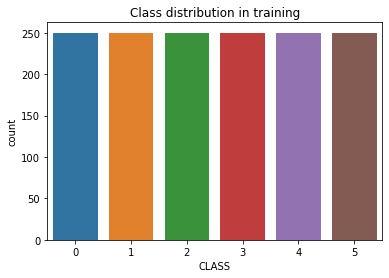

In [62]:
sns.countplot(x = Y_train)
plt.title('Class distribution in training')
plt.show()

In [ ]:
with open('X_test_list_k3.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('Y_test_list_k3.pkl', 'rb') as f:
    Y_test = pickle.load(f)

X_test[0].shape, Y_test[0].shape    

In [ ]:
test_indicies = [2,3,4,5,1]
tests_order = [4,0,1,2,3] # the order that test sets are saved in Y_test
fig, ax= plt.subplots(1,len(Y_test))
fig.tight_layout()

for i in range(len(Y_test)):
    ax[i].set_title('test set '+ str(i+1))   
    sns.countplot(x = Y_test[tests_order[i]], ax=ax[i])

fig.show()

In [26]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [43]:
X_embedded_tsne = TSNE(n_components=2, init='random').fit_transform(X_train)
X_embedded_tsne.shape

(1500, 2)

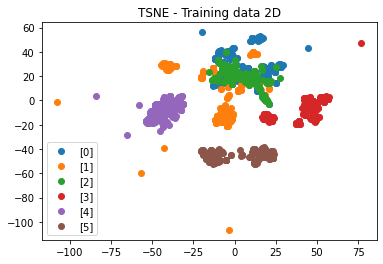

In [60]:
labels = []
lower_bound = 0
for k in range(1,7):
    upper_bound= 250*k
    plt.scatter(X_embedded_tsne[lower_bound:upper_bound,0],
                X_embedded_tsne[lower_bound:upper_bound,1]
                )
    labels.append(np.unique(Y_train[lower_bound:upper_bound]))
    lower_bound = upper_bound

plt.title('TSNE - Training data 2D')
plt.legend(labels)

In [ ]:
X_embedded_pca = PCA(n_components=2).fit_transform(X_train)

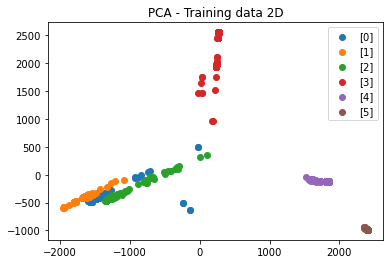

In [61]:
labels = []
lower_bound = 0
for k in range(1,7):
    upper_bound= 250*k
    plt.scatter(X_embedded_pca[lower_bound:upper_bound,0],
                X_embedded_pca[lower_bound:upper_bound,1]
                )
    labels.append(np.unique(Y_train[lower_bound:upper_bound]))
    lower_bound = upper_bound

plt.title('PCA - Training data 2D')
plt.legend(labels)

### Test data preparation

In [21]:
def preprocess_df_test(df_test):
    
    df_test['CLASS'] = df_test['CLASS'].apply(lambda x : x-1) # making the classes to start from class 0
    y_test = df_test['CLASS']
    
    kmer_sequences = df_test['SEQ'].apply(lambda x: kmer_fun(x, KMER))
    kmer_sequences = tokenizer.texts_to_sequences(kmer_sequences)
    
    x_test = pad_sequences(kmer_sequences, maxlen = MAXLEN)
    return np.array(x_test), np.array(y_test)

In [ ]:
X_test , Y_test = [], []

for t in os.listdir('data/covid/test'):
    df = pd.read_csv('data/covid/test/'+t)
    x_test, y_test = preprocess_df_test(df)
    print(t , ' Processed', ', length: ', len(df))
    X_test.append(x_test)
    Y_test.append(y_test)

test_(2).csv  Processed , length:  1090
test_(3).csv  Processed , length:  4000
test_(5).csv  Processed , length:  5010
test_(4).csv  Processed , length:  3500
test_(1).csv  Processed , length:  3143


In [ ]:
with open('X_test_list_k3.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('Y_test_list_k3.pkl', 'wb') as f:
    pickle.dump(Y_test, f)

### Ordinal Encoding

In [ ]:
def nucleotideToDigit(seq):
    digit_seq = []
    seq = list(seq)
    for n in seq:
        if n == 'T' :
            d = -1.5
        elif n =='C' : 
            d = 0.5
        elif n == 'A' :
            d = 1.5
        elif n == 'G' :
            d = -0.5
        else:
            d = 0
        digit_seq.append(d)
    
    return np.array(digit_seq)
     
nucleotideToDigit('ACTGN')

array([ 1.5,  0.5, -1.5, -0.5,  0. ])

In [ ]:
df_training = pd.read_csv('data/covid/training.csv')
df_training.head()

,PID,CLASS,CLASSNAME,SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,1,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...
1,AH013708 |SARS coronavirus Sin0409| partial se...,1,SARS-COV-1,CATTCAGTACGGTCGTAGCGGTATAACACTGGGAGTACTCGTGCCA...
2,AH013709 |SARS coronavirus Sin_WNV| partial se...,1,SARS-COV-1,CACGCGCGGGCAAGTCAATGTGCACTCTTTCCGAACAACTTGATTA...
3,AP006557 |SARS coronavirus TWH genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...
4,AP006558 |SARS coronavirus TWJ genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...


In [ ]:
df_training['ORDINAL_SEQ'] = df_training['SEQ'].apply(lambda x: nucleotideToDigit(x))
df_training.head()

,PID,CLASS,CLASSNAME,SEQ,ORDINAL_SEQ
0,AB257344 |SARS coronavirus Frankfurt 1 genomic...,1,SARS-COV-1,GATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTA...,"[-0.5, 1.5, -1.5, 0.5, -1.5, 0.5, -1.5, -1.5, ..."
1,AH013708 |SARS coronavirus Sin0409| partial se...,1,SARS-COV-1,CATTCAGTACGGTCGTAGCGGTATAACACTGGGAGTACTCGTGCCA...,"[0.5, 1.5, -1.5, -1.5, 0.5, 1.5, -0.5, -1.5, 1..."
2,AH013709 |SARS coronavirus Sin_WNV| partial se...,1,SARS-COV-1,CACGCGCGGGCAAGTCAATGTGCACTCTTTCCGAACAACTTGATTA...,"[0.5, 1.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0..."
3,AP006557 |SARS coronavirus TWH genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,"[1.5, -1.5, 1.5, -1.5, -1.5, 1.5, -0.5, -0.5, ..."
4,AP006558 |SARS coronavirus TWJ genomic RNA| co...,1,SARS-COV-1,ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCT...,"[1.5, -1.5, 1.5, -1.5, -1.5, 1.5, -0.5, -0.5, ..."


In [ ]:
len(df_training.iloc[1]['SEQ']), len(df_training.iloc[1]['ORDINAL_SEQ']), df_training.iloc[1]['PID']

(25665, 25665, 'AH013708 |SARS coronavirus Sin0409| partial sequence')

In [ ]:
print('Average length of the seqeunces: ', int(np.mean(df_training['ORDINAL_SEQ'].str.len())))
maxlen = np.max(df_training['ORDINAL_SEQ'].str.len())
maxlen

Average length of the seqeunces:  20151


30123

In [ ]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(df_training['ORDINAL_SEQ'], maxlen = maxlen)
x_train.shape, type(x_train)

((1500, 30123), numpy.ndarray)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
x_train_smallerdim = pca.fit_transform(x_train)
x_train_smallerdim.shape

(1500, 200)

In [ ]:
y_train = df_training['CLASS']
y_train.shape

(1500,)